In [52]:
import torch
from torch.utils.data import Dataset
import numpy as np
from torchmetrics.classification import MulticlassAccuracy
from torchvision import datasets
from torchvision.transforms import v2


transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomRotation(degrees=30),
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transforms_test = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [53]:
cifar_dataset_train = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms,
)

cifar_dataset_test = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transforms_test,
)


Files already downloaded and verified
Files already downloaded and verified


In [54]:
image, label = cifar_dataset_train[0]
image, label

(Image([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],
 
        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],
 
        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], ),
 6)

In [55]:
image.shape


torch.Size([3, 32, 32])

In [56]:
len(cifar_dataset_train.targets), len(cifar_dataset_test.targets), len(cifar_dataset_train.classes), len(cifar_dataset_test.classes)

(50000, 10000, 10, 10)

In [57]:
class_names = cifar_dataset_train.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Image shape: torch.Size([3, 32, 32])


Text(0.5, 1.0, '6')

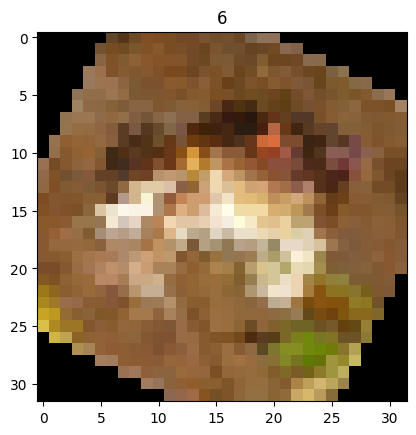

In [58]:
from matplotlib import pyplot as plt
image, label = cifar_dataset_train[0]
print(f"Image shape: {image.shape}")
image = image.permute(1, 2, 0)
plt.imshow(image.squeeze())
plt.title(label)

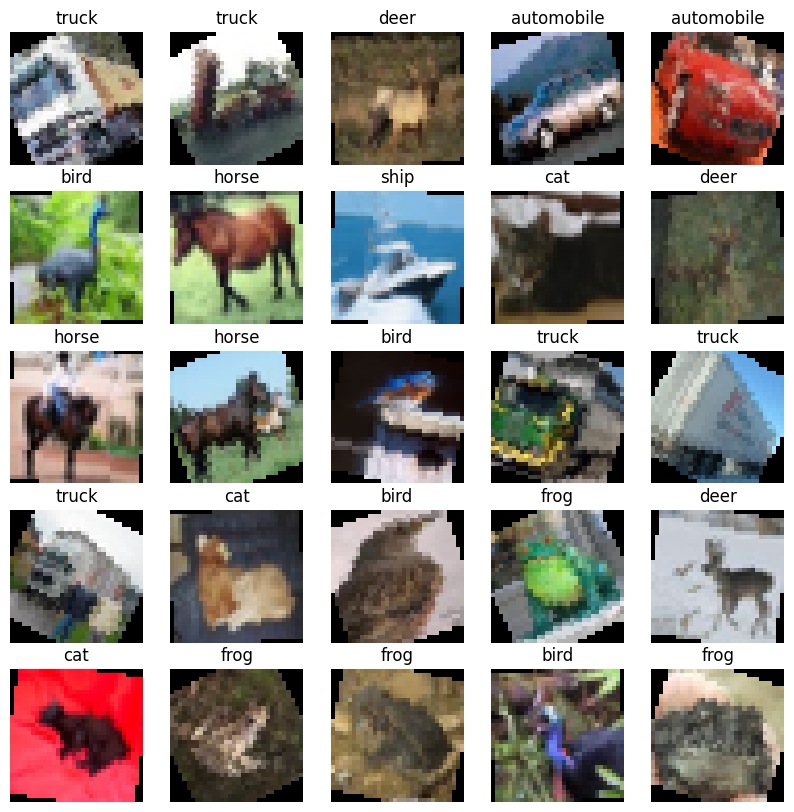

In [59]:

torch.manual_seed(42)
fig = plt.figure(figsize=(10, 10))
rows, cols = 5, 5
for i in range(1, rows * cols + 1):
    image, label = cifar_dataset_train[i]
    image = image.permute(1, 2, 0)
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis("off")

In [82]:
from torch.utils.data import DataLoader

train_Loader = DataLoader(cifar_dataset_train, batch_size=128, shuffle=True)
test_Loader = DataLoader(cifar_dataset_test, batch_size=128, shuffle=True)

from torch import nn

class CIFARModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(in_features=256*4*4, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=10),
        )
    def forward(self, x):
        return self.model(x)


In [83]:
model_1 = CIFARModel().to("mps")

In [84]:
from torchinfo import summary
summary(model_1, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CIFARModel                               [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           896
│    └─ReLU: 2-2                         [1, 32, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 64, 32, 32]           18,496
│    └─ReLU: 2-4                         [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-5                    [1, 64, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 128, 16, 16]          73,856
│    └─ReLU: 2-7                         [1, 128, 16, 16]          --
│    └─Conv2d: 2-8                       [1, 128, 16, 16]          147,584
│    └─ReLU: 2-9                         [1, 128, 16, 16]          --
│    └─MaxPool2d: 2-10                   [1, 128, 8, 8]            --
│    └─Conv2d: 2-11                      [1, 256, 8, 8]            295,

In [96]:
from torchmetrics import Accuracy
device = "mps"
accuracy = Accuracy(task="multiclass", num_classes=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

In [126]:
# Build a function to train the model

epochs = 50

# Define the training loop
def train_epoch(train_DataLoader, model, loss_fn, optimizer):
    size = len(train_DataLoader.dataset)
    model.train()
    total_loss = 0
    accuracy_instance = Accuracy(task="multiclass", num_classes=10).to(device)
    for batch, (X, y) in enumerate(train_DataLoader):
        X, y = X.to("mps"), y.to("mps")
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        accuracy_instance.update(pred, y)
        if batch % 10000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            print(f"Accuracy:  {accuracy_instance.compute():.4f}")

        accuracy.reset()
    train_loss = total_loss / len(train_DataLoader)
    train_accuracy = accuracy.compute()
    return train_loss, train_accuracy

# Define the test loop
"""def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    test_accuracy = accuracy()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to("mps"), y.to("mps")
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            accuracy.update(pred, y)
    test_loss /= num_batches
    print(f"Test Error: \n Accuracy: {(100*test_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, test_accuracy
    """



'def test_loop(dataloader, model, loss_fn):\n    size = len(dataloader.dataset)\n    num_batches = len(dataloader)\n    model.eval()\n    test_loss = 0\n    test_accuracy = accuracy()\n    with torch.no_grad():\n        for X, y in dataloader:\n            X, y = X.to("mps"), y.to("mps")\n            pred = model(X)\n            test_loss += loss_fn(pred, y).item()\n            accuracy.update(pred, y)\n    test_loss /= num_batches\n    print(f"Test Error: \n Accuracy: {(100*test_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")\n    return test_loss, test_accuracy\n    '

In [129]:
model_1.to("mps")

# Train the model
epochs = 5
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

def train_loop(train_dataloader, test_dataloader, model, loss_fn, epochs, optimizer):
    for epoch in range(epochs):
        # Training code here...
        train_loss, train_accuracy = train_epoch(train_dataloader, model, loss_fn, optimizer)
        test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn)

        # Store accuracy and loss values
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

def test_loop(test_dataLoader, model, loss_fn):
    size = len(test_dataLoader.dataset)
    num_batches = len(test_dataLoader)
    model.eval()
    test_loss = 0
    accuracy_test_loop = Accuracy(task="multiclass", num_classes=10).to(device).to(device)
    with torch.no_grad():
        for X, y in test_dataLoader:
            X, y = X.to("mps"), y.to("mps")
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            accuracy_test_loop.update(pred, y)

    test_loss /= num_batches
    test_accuracy = accuracy_test_loop.compute()
    epoch = 1
    print(f"Epoch: {epoch} : Accuracy: {(100*test_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    epoch += 1
    return test_loss, test_accuracy



In [130]:
train_loop(train_dataloader=train_Loader, test_dataloader=test_Loader, model=model_1, loss_fn=loss_fn, epochs=epochs, optimizer=optimizer)

loss: 0.518328  [    0/50000]
Accuracy:  0.8125
Epoch: 1 : Accuracy: 78.1%, Avg loss: 0.647616 

loss: 0.558614  [    0/50000]
Accuracy:  0.7891
Epoch: 1 : Accuracy: 78.2%, Avg loss: 0.641531 

loss: 0.635951  [    0/50000]
Accuracy:  0.7969
Epoch: 1 : Accuracy: 78.5%, Avg loss: 0.631843 

loss: 0.532741  [    0/50000]
Accuracy:  0.8203
Epoch: 1 : Accuracy: 79.0%, Avg loss: 0.629948 

loss: 0.539875  [    0/50000]
Accuracy:  0.8125
Epoch: 1 : Accuracy: 80.2%, Avg loss: 0.575983 



In [143]:
train_accuracies[0:10]

[tensor(0., device='mps:0'),
 tensor(3.6099e-34, device='mps:0'),
 tensor(0., device='mps:0'),
 tensor(0., device='mps:0'),
 tensor(0., device='mps:0')]

In [134]:
import matplotlib.pyplot as plt

# Convert accuracy objects to float values and move to CPU if needed
train_acc_values = train_accuracies.Tensor.cpu()
test_acc_values = [acc.cpu().item() if hasattr(acc, 'cpu') else acc for acc in test_accuracies]

# No need to modify loss values if they're already floats
train_losses = train_losses
test_losses = test_losses

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

AttributeError: 'list' object has no attribute 'Tensor'